# Stability: 
An XAI will produce similar explanations for two similar inputs IF both the inputs are classified into one class.

To create clusters of your peptides, use gibbscluter: https://services.healthtech.dtu.dk/services/GibbsCluster-2.0/.
Set $\lambda$ low (0.05) if inputs are similar (Which we expect in case of binder peptides of an MHC allele)

In [3]:
import subprocess
import sys
import numpy as np
from numpy import mean
from numpy import var
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
from scipy.stats.stats import pearsonr 
from scipy.spatial import distance
from sklearn import metrics
import pickle
from collections import Counter
%matplotlib inline

In [1]:
def sort_pos(ls):
    ls_dict = {k:v for v,k in enumerate(ls)}
    sorted_ls = sorted(ls,reverse=True)
    return [ls_dict[k] for k in sorted_ls]

    
def distance_between_examples(cluster1,cluster2,df,xai):
    dist_cluster = []
    for idx, a in enumerate(cluster1):
        for jdx, b in enumerate(cluster2): 
            if jdx>idx:
                if xai == 'SHAP':
                    ls1 = list(df.loc[a])
                    ls2 = list(df.loc[b])
                    dist_cluster = dist_cluster + [distance.euclidean(ls1, ls2)]
                else:
                    ls1 = list(df.loc[a])
                    ls2 = list(df.loc[b])
                    dist_cluster = dist_cluster + [distance.euclidean(ls1[1:10], ls2[1:10])]
    return dist_cluster

def get_cluster(f, nclusters):
    cluster_dict = {'c'+str(i+1):[] for i in range(nclusters)}
    group_num = 1
    for line in f:
        if '##' in line:
            k = 'c'+str(group_num)
            group_num = group_num + 1
        else:
            cluster_dict[k] = cluster_dict[k] + [line[:-1]]
            
    return cluster_dict

# function to calculate Cohen's d for independent samples
def cohend(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = var(d1, ddof=1), var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = mean(d1), mean(d2)
    # calculate the effect size
    return (u1 - u2) / s

In [7]:
threshold_true = 1 - np.log(500)/np.log(50000)

# hla_list = ['HLA-A02:01','HLA-A02:07', 'HLA-B07:02','HLA-C06:02', 'HLA-C15:02', 'HLA-C14:02', 'HLA-B39:01', 'HLA-B15:17', 'HLA-A32:01', 'HLA-A24:03']
hla_list = ['HLA-A02:01']

# Get HLA specific df
df = pd.read_csv('./data/stability/A0201/mhcflurry_A0201.txt',index_col=0)
df['ps_hit'] = [1 if i>threshold_true else 0 for i in df['presentation_score']]
df = df.rename(columns={'peptide':'Peptide'})
df = df[['Peptide','ps_hit']]

# create cluster peptides
f = open('./data/stability/A0201/10clusters.txt')
nclusters = 10
sampled_cluster_dict = {'c'+str(i+1):[] for i in range(nclusters)}
cluster_dict = get_cluster(f, nclusters)

sample_n = 100

# load XAIs
path_shap = './example/raw_data/HLAA0201_SHAP_MHCFlurry.pkl'
df_shap = pd.read_pickle(path_shap)
path_lime = './example/raw_data/HLAA0201_LIME_MHCFlurry.pkl'
df_lime = pd.read_pickle(path_lime)

# load clustering report
pd.read_csv('./data/stability/A0201/10cluster_pssm/solution.txt', delim_whitespace=True).to_csv('./data/stability/A0201/10cluster_pssm/solution_df.txt')
df_report = pd.read_csv('./data/stability/A0201/10cluster_pssm/solution_df.txt',index_col=0)
    
# get sampled peptides in clusters
for i in range(nclusters):
    np.random.seed(seed=0)
    k = 'c'+str(i+1)
    df1 = pd.DataFrame({'Peptide':cluster_dict[k]})
    cluster = pd.merge(df,df1,on='Peptide')
      
    tmp_df = df_report[df_report['Gn']==i]
    peptide_df = pd.merge(cluster[cluster['ps_hit']==1]['Peptide'],
                          tmp_df,
                          left_on = 'Peptide',
                          right_on = 'Sequence')
    
    sample_n = sample_n if len(peptide_df)>sample_n else len(peptide_df)
    sampled_cluster_dict[k] = random.sample(list(peptide_df['Peptide']),sample_n)

    
# create distance dict
dist_shap_cluster = {'c'+str(i)+str(j):[] for i in range(1,nclusters+1) for j in range(i,nclusters+1)}
dist_lime_cluster = {'c'+str(i)+str(j):[] for i in range(1,nclusters+1) for j in range(i,nclusters+1)}

for i in range(1,nclusters+1):
    for j in range(i,nclusters+1):
        dist_shap_cluster['c'+str(i)+str(j)] = distance_between_examples(sampled_cluster_dict['c'+str(i)],sampled_cluster_dict['c'+str(j)],df_shap,'SHAP')
        dist_lime_cluster['c'+str(i)+str(j)] = distance_between_examples(sampled_cluster_dict['c'+str(i)],sampled_cluster_dict['c'+str(j)],df_lime,'LIME')

# Plotting - SHAP    
col1_s = []
col2_s = []
hue = []
for i in range(1,nclusters+1):
    for j in range(i+1,nclusters+1):
        col1_s = col1_s + dist_shap_cluster['c'+str(i)+str(i)] + dist_shap_cluster['c'+str(i)+str(j)] + dist_shap_cluster['c'+str(j)+str(j)]
        col2_s = col2_s + ['c'+str(i)+',c'+str(j)]*len(dist_shap_cluster['c'+str(i)+str(i)] + dist_shap_cluster['c'+str(i)+str(j)] + dist_shap_cluster['c'+str(j)+str(j)])
        hue =  hue + ['Intracluster_l']*len(dist_shap_cluster['c'+str(i)+str(i)]) + ['Intercluster']*len(dist_shap_cluster['c'+str(i)+str(j)]) + ['Intracluster_r']*len(dist_shap_cluster['c'+str(j)+str(j)])
        
        
# Plotting - SHAP    
col1_l = []
col2_l = []
hue_l = []

for i in range(1,nclusters+1):
    for j in range(i+1,nclusters+1):
        col1_l = col1_l + dist_lime_cluster['c'+str(i)+str(i)] + dist_lime_cluster['c'+str(i)+str(j)] + dist_lime_cluster['c'+str(j)+str(j)]
        col2_l = col2_l + ['c'+str(i)+',c'+str(j)]*len(dist_lime_cluster['c'+str(i)+str(i)] + dist_lime_cluster['c'+str(i)+str(j)] + dist_lime_cluster['c'+str(j)+str(j)])
        hue_l =  hue_l + ['Intracluster_l']*len(dist_lime_cluster['c'+str(i)+str(i)]) + ['Intercluster']*len(dist_lime_cluster['c'+str(i)+str(j)]) + ['Intracluster_r']*len(dist_lime_cluster['c'+str(j)+str(j)])

In [28]:
# check which clusters are least similar
col1 = []
col2 = []
sum_col = []
for i in range(nclusters):
    a = pd.read_csv('./data/stability/A0201/10cluster_pssm/gibbs.'+str(i+1)+'of10.mat',delim_whitespace=True,header=1).reset_index(drop=True)
    for j in range(i,nclusters):
        b = pd.read_csv('./data/stability/A0201/10cluster_pssm/gibbs.'+str(j+1)+'of10.mat',delim_whitespace=True,header=1).reset_index(drop=True)
        col1 = col1 + [i+1]
        col2 = col2 + [j+1]
        sum_col = sum_col + [a.T.corrwith(b.T).abs().sum()]
        
        
df = pd.DataFrame({'col1':col1,
                   'col2':col2,
                   'sum_col':sum_col})        
df.sort_values('sum_col')

# Also check these pairs with motifs just to make sure the difference

,col1,col2,sum_col
13,2,5,1.435466
38,5,9,1.726755
35,5,6,1.749398
21,3,5,1.749944
24,3,8,1.767226
7,1,8,1.938896
39,5,10,1.983001
51,8,10,2.014881
31,4,8,2.167379
42,6,8,2.203168


# SHAP Stability

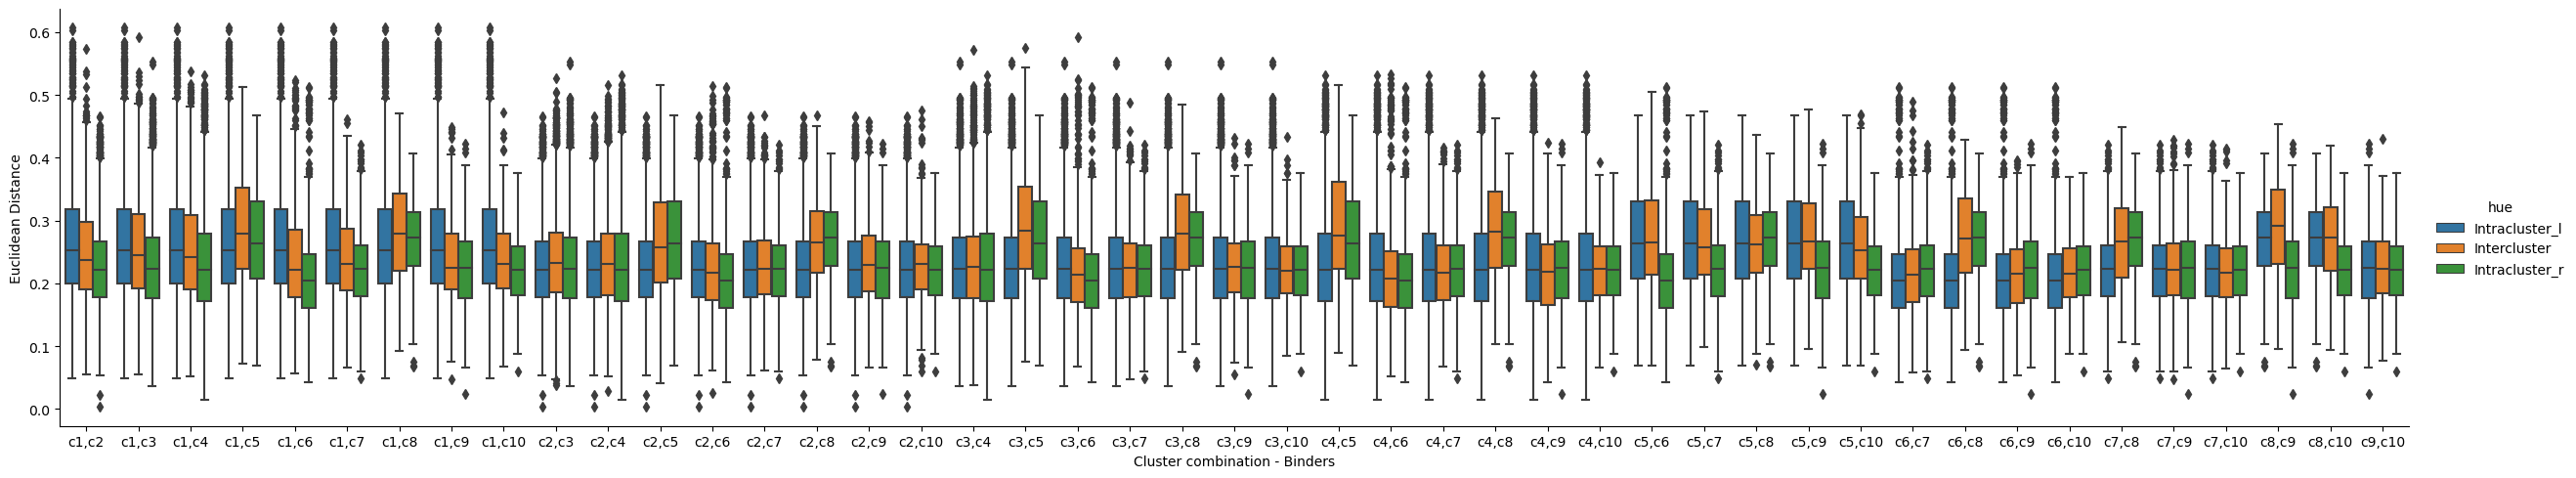

In [8]:
#SHAP plot all clusters
df = pd.DataFrame({'col1':col1_s,
                   'col2':col2_s,
                   'hue':hue})

b = sns.catplot(data = df, x='col2', y = 'col1',
                hue='hue',kind='box', aspect=5)


b.set_xlabels('Cluster combination - Binders')
b.set_ylabels('Euclidean Distance')
plt.show()

In [34]:
# .csv of for unrelated clusters
col1 = []
col2 = []
hue = []
for i,j in zip([2,3,5,5,5,3],[5,5,6,9,10,8]):
    col1 = col1 + dist_shap_cluster['c'+str(i)+str(i)] + dist_shap_cluster['c'+str(i)+str(j)] + dist_shap_cluster['c'+str(j)+str(j)]
    col2 = col2 + ['c'+str(i)+',c'+str(j)]*len(dist_shap_cluster['c'+str(i)+str(i)] + dist_shap_cluster['c'+str(i)+str(j)] + dist_shap_cluster['c'+str(j)+str(j)])
    hue =  hue + ['Intracluster_l']*len(dist_shap_cluster['c'+str(i)+str(i)]) + ['Intercluster']*len(dist_shap_cluster['c'+str(i)+str(j)]) + ['Intracluster_r']*len(dist_shap_cluster['c'+str(j)+str(j)])

df = pd.DataFrame({'col1':col1,
                   'col2':col2,
                   'hue':hue})
df.to_csv('./data/stability/A0201/Stability_SHAP.csv')


,col1,col2,hue
0,0.292315,"c2,c5",Intracluster_l
1,0.236270,"c2,c5",Intracluster_l
2,0.275104,"c2,c5",Intracluster_l
3,0.289714,"c2,c5",Intracluster_l
4,0.160422,"c2,c5",Intracluster_l
...,...,...,...
27787,0.362476,"c3,c8",Intracluster_r
27788,0.254791,"c3,c8",Intracluster_r
27789,0.323296,"c3,c8",Intracluster_r
27790,0.339512,"c3,c8",Intracluster_r


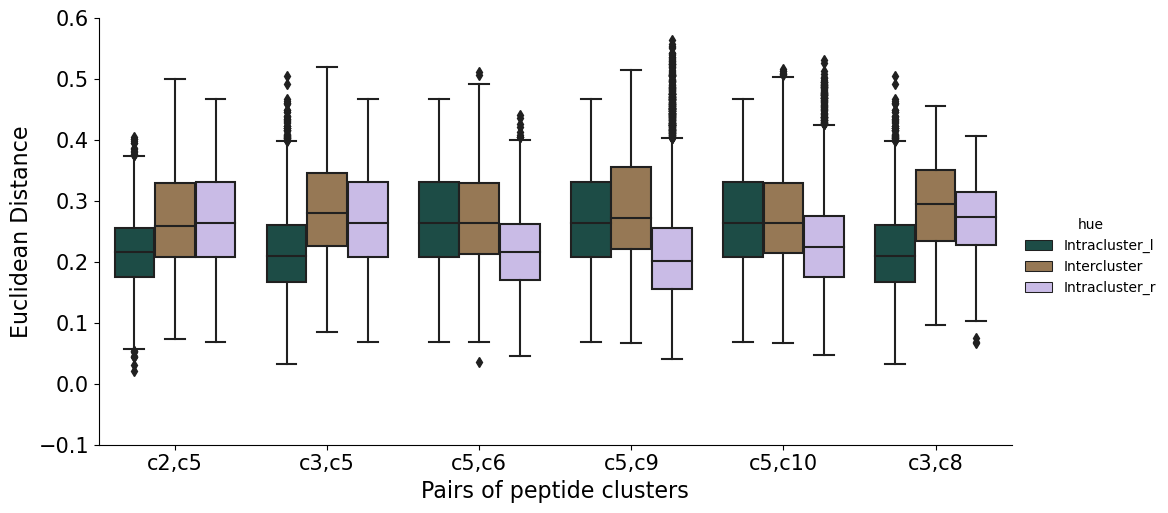

In [33]:
# Plot
df = pd.read_csv('./data/stability/A0201/Stability_SHAP.csv',index_col=0)

hue_plot_params = {'data':df, 'x':'col2', 'y':'col1','hue':'hue','kind':'box', 'aspect':2}

b = sns.catplot(**hue_plot_params, palette='cubehelix')
    
b.set_xlabels('Pairs of peptide clusters',size=16)
b.set_ylabels('Euclidean Distance',size=16)
b.set_xticklabels(size=15)
b.set_yticklabels( size=15)
plt.show()

In [36]:
# Significance statistics pvalues
df = pd.read_csv('./data/stability/A0201/Stability_SHAP.csv',index_col=0)

for pairs in set(df['col2']):
    print(pairs)
    df_tmp = df[df['col2']==pairs]
    d1 = list(df_tmp[df_tmp['hue']=='Intracluster_l']['col1'])
    d2 = list(df_tmp[df_tmp['hue']=='Intercluster']['col1'])
    d3 = list(df_tmp[df_tmp['hue']=='Intracluster_r']['col1'])
    
    print(stats.kruskal(d1,d2)[1], stats.kruskal(d1,d2)[0], cohend(d1,d2))
    print(stats.kruskal(d2,d3)[1], stats.kruskal(d2,d3)[0], cohend(d2,d3))
    print(stats.kruskal(d1,d3)[1], stats.kruskal(d1,d3)[0], cohend(d1,d3))

c3,c8
1.4245713476658047e-80 361.3589216614637 -1.0770028683092425
1.1527471161029439e-05 19.239964948792476 0.29215967953054567
2.0768600269367594e-56 250.44508613557264 -0.7837032985160212
c5,c10
0.06460512169509272 3.415033004774159 -0.09981882531304942
1.4315235137766352e-133 604.9102007481597 0.5817400918518777
3.665476921180045e-48 212.62981868787028 0.495370542715787
c5,c6
0.11936057466194228 2.4256913108220033 -0.07747866067414119
3.758593539395e-199 906.5173842474323 0.7576114964317189
3.2288107681106633e-75 336.76666778596336 0.7132243600391722
c3,c5
1.245886851588106e-145 660.3625927239882 -1.0140557544067619
5.611132808915514e-07 25.041439112286753 0.2325094035970557
1.2733480837126756e-86 389.14070594186705 -0.7477138318753593
c5,c9
2.7282963955517455e-09 35.368748159082315 -0.24186421801076977
0.0 1470.400158449007 0.8470257035562777
3.983884704961712e-93 419.02206135018787 0.6205814277479818
c2,c5
1.5224214288057623e-81 365.8190290638122 -0.842955768394646
0.964835899070

# LIME Stability

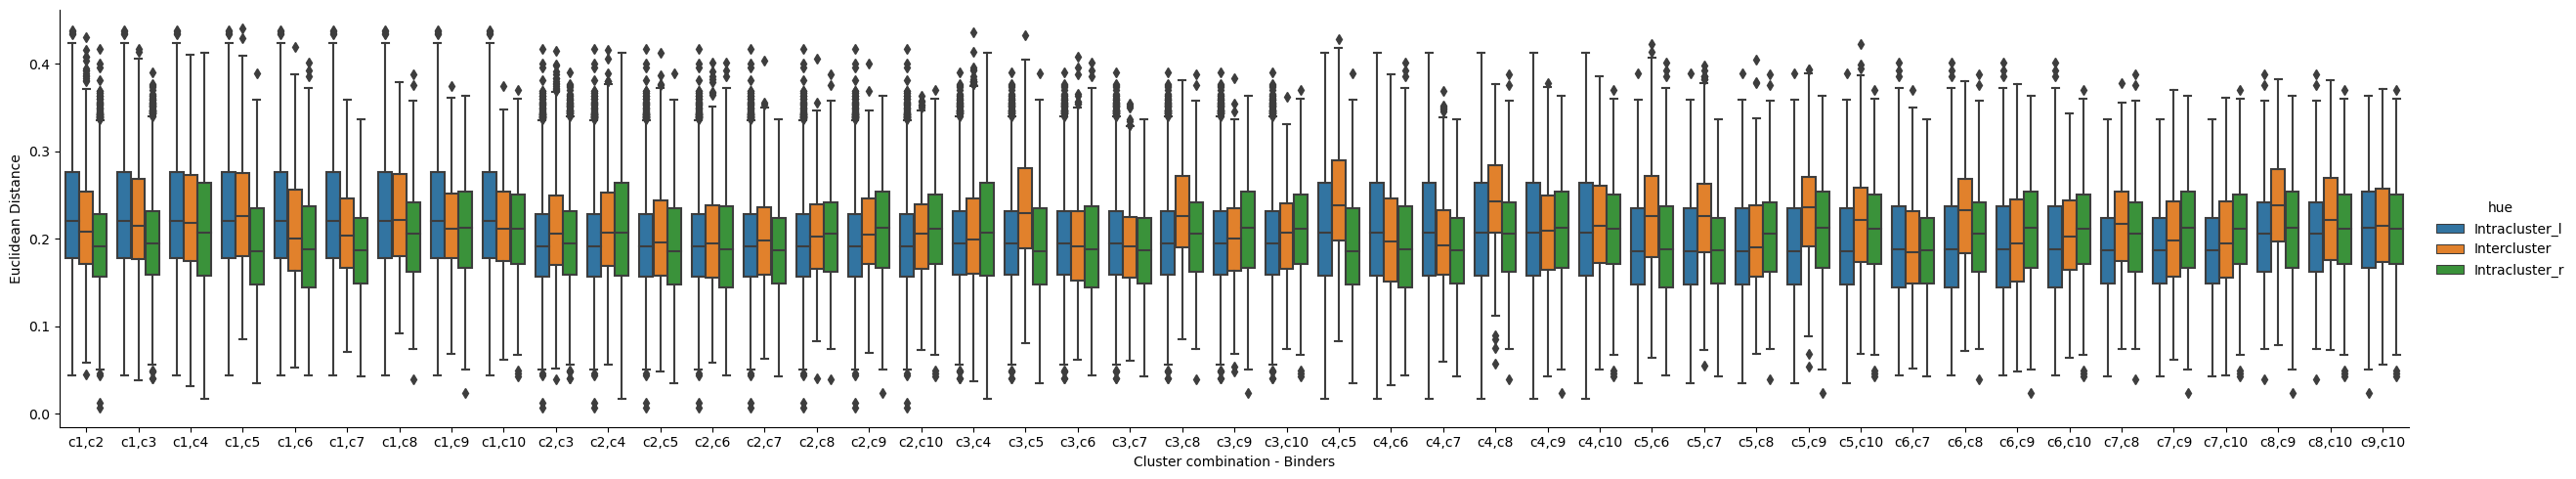

In [41]:
# LIME all clusters
df = pd.DataFrame({'col1':col1_l,
                   'col2':col2_l,
                   'hue':hue_l})

b = sns.catplot(data = df, x='col2', y = 'col1',
                hue='hue',kind='box', aspect=5)


b.set_xlabels('Cluster combination - Binders')
b.set_ylabels('Euclidean Distance')
plt.show()


In [42]:
# LIME
col1 = []
col2 = []
hue = []
for i,j in zip([2,3,5,5,5,3],[5,5,6,9,10,8]):
    col1 = col1 + dist_lime_cluster['c'+str(i)+str(i)] + dist_lime_cluster['c'+str(i)+str(j)] + dist_lime_cluster['c'+str(j)+str(j)]
    col2 = col2 + ['c'+str(i)+',c'+str(j)]*len(dist_lime_cluster['c'+str(i)+str(i)] + dist_lime_cluster['c'+str(i)+str(j)] + dist_lime_cluster['c'+str(j)+str(j)])
    hue =  hue + ['Intracluster_l']*len(dist_lime_cluster['c'+str(i)+str(i)]) + ['Intercluster']*len(dist_lime_cluster['c'+str(i)+str(j)]) + ['Intracluster_r']*len(dist_lime_cluster['c'+str(j)+str(j)])

df = pd.DataFrame({'col1':col1,
                   'col2':col2,
                   'hue':hue})
df.to_csv('./data/stability/A0201/Stability_LIME.csv')


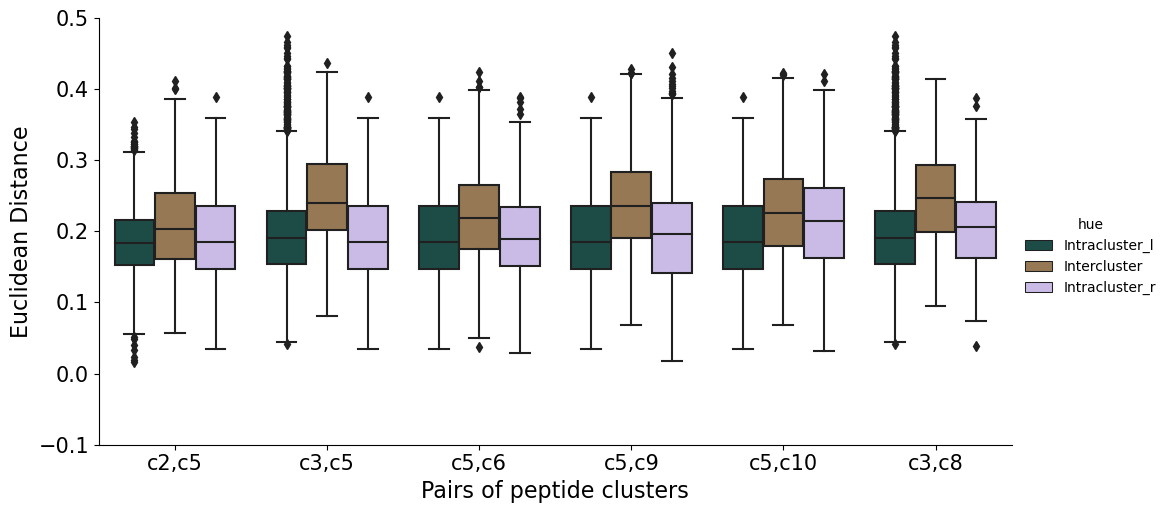

In [43]:
df = pd.read_csv('./data/stability/A0201/Stability_LIME.csv',index_col=0)

hue_plot_params = {'data':df, 'x':'col2', 'y':'col1','hue':'hue','kind':'box', 'aspect':2}
b = sns.catplot(**hue_plot_params, palette='cubehelix')
    
b.set_xlabels('Pairs of peptide clusters',size=16)
b.set_ylabels('Euclidean Distance',size=16)
b.set_xticklabels(size=15)
b.set_yticklabels(size=15)
plt.show()

In [40]:
# Statistical Significance 
df = pd.read_csv('./data/stability/A0201/Stability_LIME.csv',index_col=0)

for pairs in set(df['col2']):
    print(pairs)
    df_tmp = df[df['col2']==pairs]
    d1 = list(df_tmp[df_tmp['hue']=='Intracluster_l']['col1'])
    d2 = list(df_tmp[df_tmp['hue']=='Intercluster']['col1'])
    d3 = list(df_tmp[df_tmp['hue']=='Intracluster_r']['col1'])
    
    print(stats.kruskal(d1,d2)[1], stats.kruskal(d1,d2)[0], cohend(d1,d2))
    print(stats.kruskal(d2,d3)[1], stats.kruskal(d2,d3)[0], cohend(d2,d3))
    print(stats.kruskal(d1,d3)[1], stats.kruskal(d1,d3)[0], cohend(d1,d3))

c3,c8
7.986917647673141e-57 252.34884712181156 -0.8196078571271311
6.72006925488775e-21 87.94792155056939 0.6541829225499489
2.9964186369215206e-05 17.420091826925272 -0.16322571274400433
c5,c10
3.654611828926993e-56 249.3192906214408 -0.5711084396018485
5.69082650267909e-24 101.95113912971647 0.2596264505222401
1.7180726651359276e-20 86.09141284004727 -0.2989293220413065
c5,c6
1.1049627377022099e-38 169.20251443081543 -0.4630452203402722
1.1290501314383178e-87 393.97414016917173 0.47009707259583444
0.4218976794687369 0.6450231335111312 -0.01788457173478179
c3,c5
1.3022657315296998e-125 568.320290361662 -0.854870409618905
4.3796378004365425e-77 345.34230343533545 0.8697770911919394
0.2180188334695368 1.517364009097946 0.04811684105813854
c5,c9
1.8788209808587265e-87 392.95817379350046 -0.7238205398119429
4.420939142219952e-167 759.0044999431484 0.6325257462563448
0.2814750497101307 1.1599541490868432 -0.05647790654200393
c2,c5
9.022546207053386e-29 123.86388314338546 -0.487817271465359